# SDF

In [1]:
from collections import OrderedDict

#import jinja2
import matplotlib.pyplot as plot
#import os
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

%matplotlib inline

C:\Users\samth\Miniconda3\envs\econ36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
factors = pd.read_csv("C:/Data/Thesis/_Factors.csv")

myfactors = pd.read_csv("C:/Data/Thesis/_MyFactors.csv")
myfactors.iloc[:,1:] = myfactors.iloc[:,1:]*100

f = pd.concat([factors, myfactors[["HML", "HMLm", "PMU06", "PMU16", "PMU", "CMA", "WML"]]], axis=1)
f.date = pd.to_datetime(f.date.astype("str"), format="%Y%m")
f = f.set_index("date")

f.head()

,rf,rm,smb,hml,rmw,cma,wml,str,hmlm,bab,qmj,HML,HMLm,PMU06,PMU16,PMU,CMA,WML
date,,,,,,,,,,,,,,,,,,
1963-07-01,0.27,-0.39,-0.46,-0.81,0.72,-1.16,0.99,-0.04,-0.59,0.81,0.47,-0.721155,-0.864465,0.888426,0.739828,0.355650,-1.132040,0.550726
1963-08-01,0.25,5.07,-0.81,1.65,0.42,-0.40,1.08,1.36,0.28,-1.22,-0.63,1.000628,-0.060107,0.212301,0.470122,0.456718,-0.070141,1.443902
1963-09-01,0.27,-1.57,-0.48,0.19,-0.80,0.23,0.13,1.20,0.27,1.07,0.61,1.045719,1.463823,-1.169019,-1.130309,-0.665664,-0.361107,0.267052
1963-10-01,0.29,2.53,-1.29,-0.09,2.75,-2.26,3.14,-0.66,-2.11,-1.88,2.08,-0.549914,-1.635921,2.612164,3.006009,3.007174,-1.886318,3.648531
1963-11-01,0.27,-0.85,-0.85,1.71,-0.34,2.22,-0.75,1.15,0.91,-0.52,-0.88,1.288533,1.400487,-0.099125,-0.481188,-0.625498,0.314912,-1.489579


Factor weights in max Sh2 portfolio

$$E(R_p) = w'\bar{R}$$
$$Var(R_p) = w'V_Rw$$
$$Sh^2(f) = \bar{f}'V_f^{-1}\bar{f}$$

In [3]:
def E(w, R):
    """Expected return on portfolio given vector of weights `w` and matrix of returns `R`
    
    Returns scalar"""

    return w.transpose() @ pd.np.mean(R, axis=0)

def V(w, R):
    """Variance of portfolio given vector of weights `w` and matrix of returns `R`

    Returns scalar"""

    return w.transpose() @ pd.np.cov(R, rowvar=False) @ w

def SR(w, R):
    """Sharpe ratio of portfolio given weights `w` and matrix of returns `R`

    Returns scalar"""

    return (E(w, R) / pd.np.sqrt(V(w, R)))

def obj_SR(*args, **kwargs):
    """Objective function to minimize negative Sharpe ratio.

    Wrapped function expects vector of weights `w` and matrix of returns `R`

    Returns optimization results object"""

    return -SR(*args, **kwargs)

# equality constraint functions are set to 0
cons = ({"type": "eq", "fun": lambda w: pd.np.sum(w) - 1},)

In [4]:
ValMom = f["1963-07":"2017-12"][["hmlm", "wml"]].as_matrix()
ValMom_res = minimize(obj_SR, [.5,.5], args=(ValMom,), constraints=cons)
ValMom_res["x"].round(2), SR(ValMom_res["x"], ValMom)

(array([0.52, 0.48]), 0.29413184785396596)

In [5]:
SDF = f["1963-07":"2017-12"][["rm", "smb", "hmlm", "wml", "PMU"]].as_matrix()
SDF_res = minimize(obj_SR, [.2,.2,.2,.2,.2], args=(SDF,), constraints=cons)
SDF_res["x"].round(2), SR(SDF_res["x"], SDF)

(array([0.1 , 0.07, 0.23, 0.14, 0.46]), 0.5624495392772361)

In [6]:
SDF2 = f["1963-07":"2017-12"][["rm", "smb", "hml", "PMU", "cma"]].as_matrix()
SDF2_res = minimize(obj_SR, [.2,.2,.2,.2,.2], args=(SDF2,), constraints=cons)
SDF2_res["x"].round(2), SR(SDF2_res["x"], SDF2)

(array([0.12, 0.1 , 0.13, 0.54, 0.12]), 0.47416457882441704)

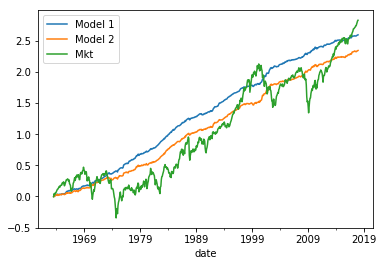

In [7]:
df = pd.DataFrame(OrderedDict([
    ("Model 1", SDF.dot(SDF_res["x"])),
    ("Model 2", SDF2.dot(SDF2_res["x"])),
    ("Mkt", f["1963-07":"2017-12"]["rm"]),
    #("Mom", f["1963-07":"2017-12"]["wml"]),
    #("Val", f["1963-07":"2017-12"]["hmlm"]),
    #("ValMom", ValMom.dot(ValMom_res["x"])),
]))/100

# (df + 1).cumprod().plot()
pd.np.log(df + 1).cumsum().plot()

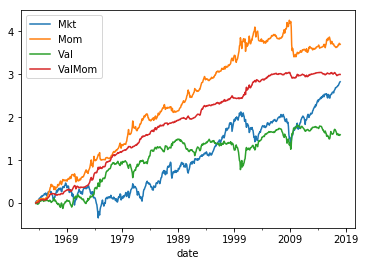

In [8]:
df = pd.DataFrame(OrderedDict([
    #("Model 1", SDF.dot(SDF_res["x"])),
    #("Model 2", SDF2.dot(SDF2_res["x"])),
    ("Mkt", f["1963-07":"2017-12"]["rm"]),
    ("Mom", f["1963-07":"2017-12"]["wml"]),
    ("Val", f["1963-07":"2017-12"]["hmlm"]),
    ("ValMom", ValMom.dot(ValMom_res["x"])),
]))/100

# (df + 1).cumprod().plot()
pd.np.log(df + 1).cumsum().plot()

In [33]:
a = pd.read_csv("C:/Data/FrenchDartmouth/25_Portfolios_ME_VAR_5x5.csv")
a.index = f.index

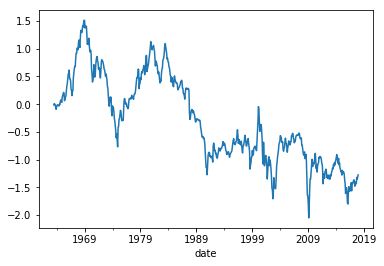

In [34]:
pd.np.log(a["SMALL HiVAR"]/100 + 1).cumsum().plot()

In [42]:
rhs = sm.add_constant(f[["rm", "smb", "hmlm", "wml", "PMU"]])
lhs = a["SMALL HiVAR"] - f["rf"]

model = sm.OLS(lhs, rhs)
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     707.4
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          1.16e-259
Time:                        15:07:15   Log-Likelihood:                -1766.7
No. Observations:                 654   AIC:                             3545.
Df Residuals:                     648   BIC:                             3572.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7531      0.163     -4.634      0.000      -1.072      -0.434
rm             1.1867      0.037     32.194      0.000       1.114       1.259
smb            1.5062      0.051     29.597      0.000       1.406       1.606
hmlm          -0.0046      0.060     -0.077      0.939      -0.123       0.113
wml           -0.3608      0.046     -7.824      0.000      -0.451      -0.270
PMU           -0.5031      0.121     -4.158      0.000      -0.741      -0.266
==============================================================================
Omnibus:                      198.338   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2179.608
Skew:                           1.018   Prob(JB):                         0.00
Kurtosis:                      11.709   Cond. No.                         6.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
rhs = sm.add_constant(f[["rm", "smb", "hml", "PMU", "cma"]])
lhs = a["SMALL HiVAR"] - f["rf"]

model = sm.OLS(lhs, rhs)
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     596.9
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          9.04e-240
Time:                        14:59:38   Log-Likelihood:                -1812.9
No. Observations:                 654   AIC:                             3638.
Df Residuals:                     648   BIC:                             3665.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8015      0.168     -4.763      0.000      -1.132      -0.471
rm             1.1802      0.041     29.122      0.000       1.101       1.260
smb            1.4584      0.055     26.715      0.000       1.351       1.566
hml           -0.0195      0.079     -0.246      0.805      -0.175       0.136
PMU           -0.8571      0.126     -6.813      0.000      -1.104      -0.610
cma           -0.1391      0.111     -1.254      0.210      -0.357       0.079
==============================================================================
Omnibus:                      324.208   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6782.498
Skew:                           1.714   Prob(JB):                         0.00
Kurtosis:                      18.400   Cond. No.                         5.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""